# 安裝與匯入套件

In [1]:
import os
import random
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# 環境設定

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# 假設 Notebook 的根目錄是 /mnt/data/DL_Report1

Using device: cuda


# 資料集與資料前處理

In [3]:
class ImageNetMiniDataset(Dataset):
    def __init__(self, txt_file, img_root, transform=None):
        with open(txt_file, 'r', encoding='utf-8') as f:
            lines = [l.strip().split() for l in f if l.strip()]
        self.samples = [(os.path.join(img_root, rel_path), int(lbl)) for rel_path, lbl in lines]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# 前處理
IMG_SIZE = 32
train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

data_root = "../image"

bs = 64
train_ds = ImageNetMiniDataset(
    txt_file=os.path.join(data_root, "train.txt"),
    img_root=data_root,
    transform=train_tf
)
val_ds = ImageNetMiniDataset(
    txt_file=os.path.join(data_root, "val.txt"),
    img_root=data_root,
    transform=eval_tf
)
test_ds = ImageNetMiniDataset(
    txt_file=os.path.join(data_root, "test.txt"),
    img_root=data_root,
    transform=eval_tf
)

train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=0)

print("訓練樣本數:", len(train_ds))
print("驗證樣本數:", len(val_ds))
print("測試樣本數:", len(test_ds))


訓練樣本數: 63325
驗證樣本數: 450
測試樣本數: 450


# ResNet34 與 TinyViT 模組架構

In [15]:
# Baseline
def build_resnet34(num_classes):
    model = models.resnet34(num_classes=num_classes)
    return model.to(device)


In [13]:
# ——— Transformer Block — (batch_first=True) ——
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn   = nn.Sequential(
            nn.Linear(dim, 4*dim),
            nn.GELU(),
            nn.Linear(4*dim, dim),
        )

    def forward(self, x):
        # x: (B, seq_len, dim)
        x_ln = self.norm1(x)
        attn_out, _ = self.attn(x_ln, x_ln, x_ln)
        x = x + attn_out
        x_ln2 = self.norm2(x)
        x = x + self.ffn(x_ln2)
        return x

# ——— TinyViT with Patch Embedding ———
class TinyViTPatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, dim=256, heads=8, num_classes=100):
        super().__init__()
        assert img_size % patch_size == 0, "img_size 必須能被 patch_size 整除"
        num_patches = (img_size // patch_size) ** 2  # 14×14=196

        # 有效層1: Patch Embedding (224→14)
        self.patch_embed = nn.Conv2d(
            in_ch, dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        self.pos_emb = nn.Parameter(torch.zeros(num_patches, dim))

        # 有效層2+3: Transformer Block
        self.transformer = TransformerBlock(dim, heads)

        # 分類頭 (LayerNorm + Linear)
        self.cls_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        # x: (B,3,224,224)
        x = self.patch_embed(x)                    # → (B,dim,14,14)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1,2)            # → (B,196,dim)
        x = x + self.pos_emb.unsqueeze(0)          # 加上位置編碼
        x = self.transformer(x)                    # TransformerBlock
        x = x.mean(dim=1)                          # 全域平均池化 → (B,dim)
        return self.cls_head(x)                    # → (B,num_classes)

num_cls   = max(lbl for _, lbl in train_ds.samples) + 1
resnet    = build_resnet34(num_cls)
tiny_emb  = TinyViTPatchEmbed(IMG_SIZE, 16, 3, 256, 8, num_cls).to(device)

macs_r, params_r = get_model_complexity_info(
    resnet,    (3, IMG_SIZE, IMG_SIZE),
    as_strings=False, print_per_layer_stat=False
)
macs_t, params_t = get_model_complexity_info(
    tiny_emb,  (3, IMG_SIZE, IMG_SIZE),
    as_strings=False, print_per_layer_stat=False
)

print(f"ResNet34 Params: {params_r/1e6:.2f}M, FLOPs: {macs_r/1e9:.2f}G")
print(f"TinyViTPE Params: {params_t/1e6:.2f}M, FLOPs: {macs_t/1e9:.2f}G")


ResNet34 Params: 21.31M, FLOPs: 0.08G
TinyViTPE Params: 1.00M, FLOPs: 0.00G


# Baseline 訓練 5 epochs 並記錄

In [9]:
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, device):
    model.train()
    correct = total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss  = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, p = preds.max(1)
        correct += (p == labels).sum().item()
        total   += labels.size(0)
    return correct / total

def eval_epoch(model, loader, device, phase="Val"):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            _, p = preds.max(1)
            correct += (p == labels).sum().item()
            total   += labels.size(0)
    return correct / total


In [10]:
#  Baseline ResNet34 訓練與記錄

criterion = nn.CrossEntropyLoss()

resnet = build_resnet34(num_cls).to(device)
opt_r   = optim.AdamW(resnet.parameters(), lr=1e-3)

res_stats = {'epoch':[], 'val_acc':[], 'test_acc':[], 'flops':[], 'params':[]}

for ep in range(1, 6):
    # —— Train Phase —— 
    correct = total = 0
    desc = f"Train Epoch {ep:2d}"
    train_bar = tqdm(train_loader, desc=desc, ncols=80, leave=True)
    for imgs, labels in train_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = resnet(imgs)
        loss  = criterion(preds, labels)
        opt_r.zero_grad()
        loss.backward()
        opt_r.step()
        _, p = preds.max(1)
        correct += (p == labels).sum().item()
        total   += labels.size(0)
    train_acc = correct / total

    # —— Validation Phase —— 
    val_acc = eval_epoch(resnet, val_loader, device, phase="Val")

    # —— Test Phase —— 
    test_acc = eval_epoch(resnet, test_loader, device, phase="Test")

    # 把 val_acc 與 test_acc 加到進度條後綴
    train_bar.set_postfix({
        'train_acc': f"{train_acc:.4f}",
        'val_acc':   f"{val_acc:.4f}",
        'test_acc':  f"{test_acc:.4f}"
    })
    train_bar.refresh()
    train_bar.close()

    # 紀錄
    res_stats['epoch'].append(ep)
    res_stats['val_acc'].append(val_acc)
    res_stats['test_acc'].append(test_acc)
    res_stats['flops'].append(macs_r)
    res_stats['params'].append(params_r)

    print(f"[Epoch {ep:2d}] Train: {train_acc*100:.2f}% | Val: {val_acc*100:.2f}% | Test: {test_acc*100:.2f}%")

# 算出 90% 閾值
baseline_val_acc = res_stats['val_acc'][-1]
target_acc       = baseline_val_acc * 0.9
print(f"Baseline 最後 Validation Acc: {baseline_val_acc*100:.2f}% → 90% 閾值: {target_acc*100:.2f}%")


Train Epoch  1: 100%|█████████████████████████| 990/990 [02:09<00:00,  7.62it/s]


[Epoch  1] Train: 9.54% | Val: 13.11% | Test: 10.67%


Train Epoch  2: 100%|█████████████████████████| 990/990 [02:11<00:00,  7.51it/s]


[Epoch  2] Train: 14.35% | Val: 15.56% | Test: 16.67%


Train Epoch  3: 100%|█████████████████████████| 990/990 [02:12<00:00,  7.49it/s]


[Epoch  3] Train: 17.84% | Val: 18.67% | Test: 18.22%


Train Epoch  4: 100%|█████████████████████████| 990/990 [02:12<00:00,  7.46it/s]


[Epoch  4] Train: 21.01% | Val: 20.44% | Test: 23.56%


Train Epoch  5: 100%|█████████████████████████| 990/990 [02:12<00:00,  7.44it/s]


[Epoch  5] Train: 24.05% | Val: 22.00% | Test: 25.33%
Baseline 最後 Validation Acc: 22.00% → 90% 閾值: 19.80%


# ResNet34 精準度分析

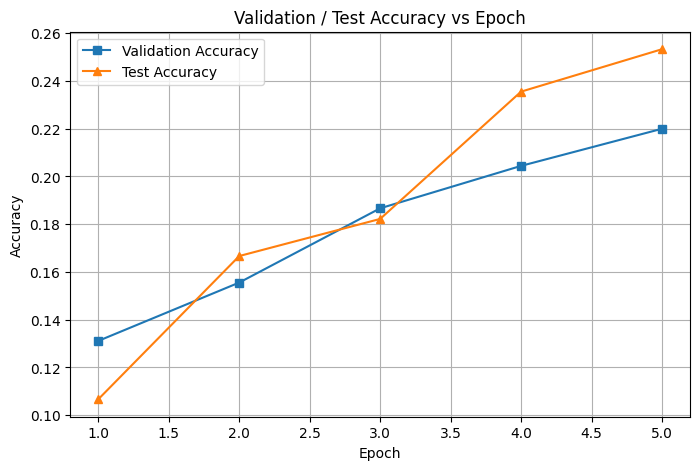

In [11]:
#  繪製 Train / Val / Test Accuracy vs Epoch
epochs    = res_stats['epoch']
val_acc   = res_stats['val_acc']
test_acc  = res_stats['test_acc']

plt.figure(figsize=(8,5))
plt.plot(epochs, val_acc,   '-s', label='Validation Accuracy')
plt.plot(epochs, test_acc,  '-^', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation / Test Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# 快速版訓練/驗證函式

In [14]:
# TinyViT 訓練
tiny = TinyViTPatchEmbed(
    img_size=IMG_SIZE,     
    patch_size=16,         
    in_ch=3,               
    dim=256,               
    heads=8,               
    num_classes=num_cls    
).to(device)

opt_t = optim.AdamW(tiny.parameters(), lr=1e-3)

tiny_stats = {'epoch': [], 'train_acc': [], 'val_acc': [], 'test_acc': [], 'flops': [], 'params': []}

max_epochs = 50  # 訓練上限
for ep in range(1, max_epochs+1):
    # —— Train Phase —— 
    correct = total = 0
    desc = f"Train Epoch {ep:2d}"
    train_bar = tqdm(train_loader, desc=desc, ncols=80, leave=True)
    for imgs, labels in train_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = tiny(imgs)
        loss  = criterion(preds, labels)
        opt_t.zero_grad()
        loss.backward()
        opt_t.step()
        _, p = preds.max(1)
        correct += (p == labels).sum().item()
        total   += labels.size(0)
    train_acc = correct / total

    val_acc = eval_epoch(tiny, val_loader, device, phase="Val")

    test_acc = eval_epoch(tiny, test_loader, device, phase="Test")

    train_bar.set_postfix({
        'train_acc': f"{train_acc:.4f}",
        'val_acc':   f"{val_acc:.4f}",
        'test_acc':  f"{test_acc:.4f}"
    })
    train_bar.refresh()
    train_bar.close()
    tiny_stats['epoch'].append(ep)
    tiny_stats['train_acc'].append(train_acc)
    tiny_stats['val_acc'].append(val_acc)
    tiny_stats['test_acc'].append(test_acc)
    tiny_stats['flops'].append(macs_t)
    tiny_stats['params'].append(params_t)
    print(f"[Epoch {ep:2d}] Train: {train_acc*100:.2f}% | Val: {val_acc*100:.2f}% | Test: {test_acc*100:.2f}%")
    if val_acc >= target_acc:
        print(f"Early stopping at epoch {ep}, val_acc={val_acc*100:.2f}% (>= {target_acc*100:.2f}%)")
        break

Train Epoch  1: 100%|█████████████████████████| 990/990 [01:57<00:00,  8.43it/s]


[Epoch  1] Train: 7.21% | Val: 7.78% | Test: 10.00%


Train Epoch  2: 100%|█████████████████████████| 990/990 [01:56<00:00,  8.49it/s]


[Epoch  2] Train: 9.76% | Val: 10.00% | Test: 10.67%


Train Epoch  3: 100%|█████████████████████████| 990/990 [01:57<00:00,  8.42it/s]


[Epoch  3] Train: 11.64% | Val: 12.22% | Test: 13.11%


Train Epoch  4: 100%|█████████████████████████| 990/990 [01:58<00:00,  8.39it/s]


[Epoch  4] Train: 13.42% | Val: 12.44% | Test: 12.44%


Train Epoch  5: 100%|█████████████████████████| 990/990 [01:58<00:00,  8.38it/s]


[Epoch  5] Train: 14.81% | Val: 16.00% | Test: 15.78%


Train Epoch  6: 100%|█████████████████████████| 990/990 [01:59<00:00,  8.30it/s]


[Epoch  6] Train: 16.04% | Val: 14.67% | Test: 15.56%


Train Epoch  7: 100%|█████████████████████████| 990/990 [01:58<00:00,  8.34it/s]


[Epoch  7] Train: 17.44% | Val: 17.11% | Test: 15.78%


Train Epoch  8: 100%|█████████████████████████| 990/990 [01:59<00:00,  8.32it/s]


[Epoch  8] Train: 18.35% | Val: 19.11% | Test: 16.00%


Train Epoch  9: 100%|█████████████████████████| 990/990 [01:56<00:00,  8.47it/s]


[Epoch  9] Train: 19.27% | Val: 18.44% | Test: 20.00%


Train Epoch 10: 100%|█████████████████████████| 990/990 [01:56<00:00,  8.50it/s]


[Epoch 10] Train: 20.20% | Val: 18.44% | Test: 19.33%


Train Epoch 11: 100%|█████████████████████████| 990/990 [01:57<00:00,  8.41it/s]


[Epoch 11] Train: 21.22% | Val: 19.33% | Test: 17.78%


Train Epoch 12: 100%|█████████████████████████| 990/990 [01:58<00:00,  8.37it/s]


[Epoch 12] Train: 22.11% | Val: 19.33% | Test: 20.22%


Train Epoch 13: 100%|█████████████████████████| 990/990 [01:58<00:00,  8.34it/s]


[Epoch 13] Train: 22.91% | Val: 18.44% | Test: 17.11%


Train Epoch 14: 100%|█████████████████████████| 990/990 [01:56<00:00,  8.53it/s]


[Epoch 14] Train: 23.93% | Val: 20.44% | Test: 18.00%
Early stopping at epoch 14, val_acc=20.44% (>= 19.80%)


# 繪製比較圖(TinyViT VS ResNet34)

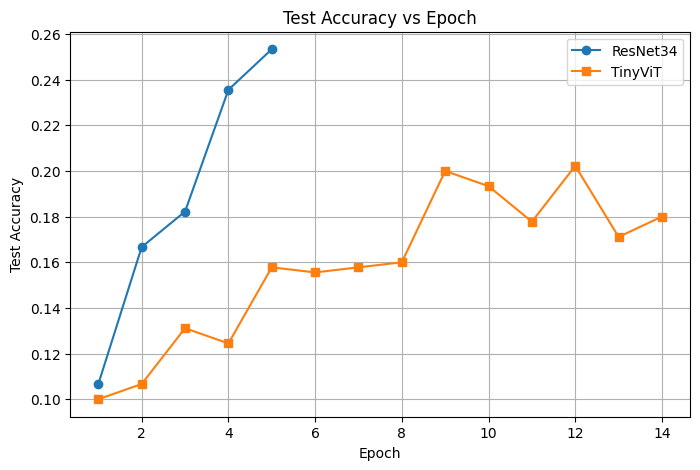

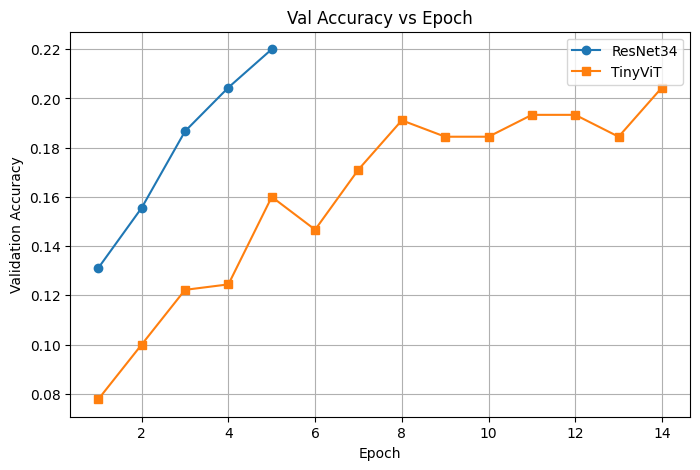

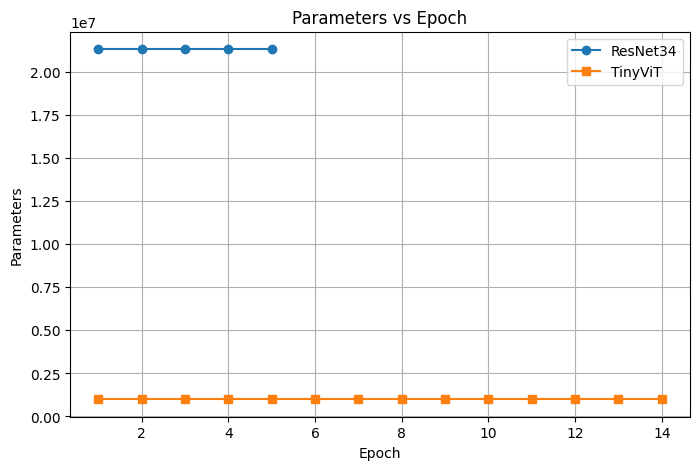

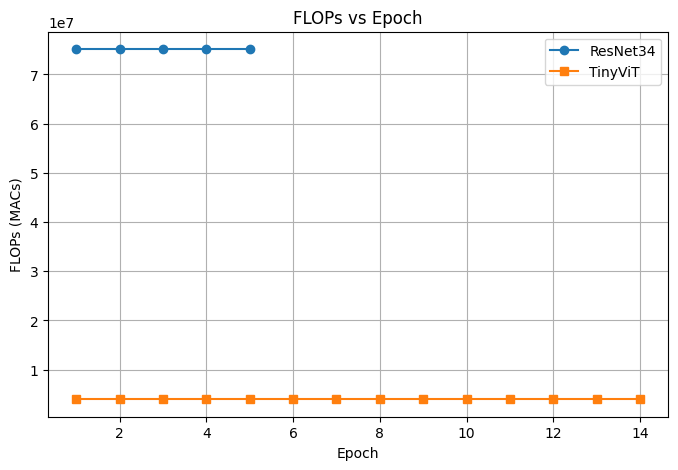

In [18]:
# ResNet34
epochs_r = list(range(1, 6))
train_acc_r = res_stats.get('test_acc', [None] * len(epochs_r))  # 若未記錄 train_acc 可為空或隨機
val_acc_r = res_stats['val_acc']
params_r = res_stats['params']
flops_r = res_stats['flops']

# TinyViT
epochs_t = tiny_stats['epoch']
train_acc_t = tiny_stats.get('test_acc', [None] * len(epochs_t))  # 若未記錄 train_acc 可為空或隨機
val_acc_t = tiny_stats['val_acc']
params_t = tiny_stats['params']
flops_t = tiny_stats['flops']

# 繪圖
plt.figure(figsize=(8, 5))
plt.plot(epochs_r, train_acc_r, '-o', label='ResNet34')
plt.plot(epochs_t, train_acc_t, '-s', label='TinyViT')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_r, val_acc_r, '-o', label='ResNet34')
plt.plot(epochs_t, val_acc_t, '-s', label='TinyViT')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Val Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_r, params_r, '-o', label='ResNet34')
plt.plot(epochs_t, params_t, '-s', label='TinyViT')
plt.xlabel('Epoch')
plt.ylabel('Parameters')
plt.title('Parameters vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_r, flops_r, '-o', label='ResNet34')
plt.plot(epochs_t, flops_t, '-s', label='TinyViT')
plt.xlabel('Epoch')
plt.ylabel('FLOPs (MACs)')
plt.title('FLOPs vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


# 消融實驗

In [26]:
# 消融實驗：TinyViT 結構變體訓練（以 90% ResNet34 為早停基準）

# 自定 Transformer Block：可選擇是否使用 MHSA 與 FFN
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, use_attn=True, use_ffn=True):
        super().__init__()
        self.use_attn = use_attn
        self.use_ffn  = use_ffn
        if use_attn:
            self.norm1 = nn.LayerNorm(dim)
            self.attn  = nn.MultiheadAttention(dim, heads, batch_first=True)
        if use_ffn:
            self.norm2 = nn.LayerNorm(dim)
            self.ffn   = nn.Sequential(
                nn.Linear(dim, 4*dim),
                nn.GELU(),
                nn.Linear(4*dim, dim),
            )

    def forward(self, x):
        if self.use_attn:
            x_ln = self.norm1(x)
            attn_out, _ = self.attn(x_ln, x_ln, x_ln)
            x = x + attn_out
        if self.use_ffn:
            x_ln2 = self.norm2(x)
            x = x + self.ffn(x_ln2)
        return x
# TinyViT with Patch Embed，支援位置編碼與可選組件
class TinyViTPatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, dim=256, heads=8, num_classes=100, 
                 use_pos=True, use_attn=True, use_ffn=True):
        super().__init__()
        assert img_size % patch_size == 0, "img_size 必須能被 patch_size 整除"
        num_patches = (img_size // patch_size) ** 2
        self.use_pos = use_pos

        self.patch_embed = nn.Conv2d(in_ch, dim, kernel_size=patch_size, stride=patch_size)
        if use_pos:
            self.pos_emb = nn.Parameter(torch.zeros(num_patches, dim))

        self.transformer = TransformerBlock(dim, heads, use_attn, use_ffn)
        self.cls_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
      x = self.patch_embed(x)                      # (B, dim, H, W)
      B, C, H, W = x.shape
      x = x.flatten(2).transpose(1, 2)             # (B, seq_len, dim)

      if self.use_pos:
         pe = self.pos_emb
         if x.shape[1] != pe.shape[0]:
             pe = pe[:x.shape[1]]   # 自動調整長度
         x = x + pe.unsqueeze(0)

      x = self.transformer(x)
      x = x.mean(dim=1)
      return self.cls_head(x)
# 訓練與評估函數
criterion = nn.CrossEntropyLoss()

def eval_epoch(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            _, p = preds.max(1)
            correct += (p == labels).sum().item()
            total += labels.size(0)
    return correct / total
# 執行指定變體的消融實驗訓練流程
ablation_variants = {
    "A1 (no PosEnc)":     {"use_pos": False},
    "A2 (FFN only)":      {"use_attn": False},
    "A3 (MHSA only)":     {"use_ffn": False},
    "A4 (patch=32)":      {"patch_size": 32},
}

for name, cfg in ablation_variants.items():
    print(f"\n 執行變體 {name}...")
    tiny_ab = TinyViTPatchEmbed(
        img_size=IMG_SIZE,
        patch_size=cfg.get("patch_size", 16),
        in_ch=3,
        dim=256,
        heads=8,
        num_classes=num_cls,
        use_pos=cfg.get("use_pos", True),
        use_attn=cfg.get("use_attn", True),
        use_ffn=cfg.get("use_ffn", True)
    ).to(device)

    macs_ab, params_ab = get_model_complexity_info(
        tiny_ab, (3, IMG_SIZE, IMG_SIZE), as_strings=False, print_per_layer_stat=False)

    opt_ab = optim.AdamW(tiny_ab.parameters(), lr=1e-3)
    stats_ab = {'epoch': [], 'val_acc': [], 'test_acc': [], 'flops': [], 'params': []}

    for ep in range(1, 51):
        tiny_ab.train()
        correct = total = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = tiny_ab(imgs)
            loss  = criterion(preds, labels)
            opt_ab.zero_grad(); loss.backward(); opt_ab.step()
            _, p = preds.max(1)
            correct += (p == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total

        val_acc = eval_epoch(tiny_ab, val_loader, device)
        test_acc = eval_epoch(tiny_ab, test_loader, device)
        print(f"[Epoch {ep:2d}] Val: {val_acc*100:.2f}% | Test: {test_acc*100:.2f}%")
        stats_ab['epoch'].append(ep)
        stats_ab['val_acc'].append(val_acc)
        stats_ab['test_acc'].append(test_acc)
        stats_ab['flops'].append(macs_ab)
        stats_ab['params'].append(params_ab)
        if val_acc >= target_acc:
            print(f" 早停！{name} 在 epoch {ep} 達成 90% 準確度門檻 ({val_acc*100:.2f}%)")
            break


 執行變體 A1 (no PosEnc)...
[Epoch  1] Val: 9.33% | Test: 8.44%
[Epoch  2] Val: 8.22% | Test: 10.89%
[Epoch  3] Val: 11.11% | Test: 10.67%
[Epoch  4] Val: 12.89% | Test: 11.78%
[Epoch  5] Val: 14.22% | Test: 14.67%
[Epoch  6] Val: 16.00% | Test: 16.67%
[Epoch  7] Val: 16.44% | Test: 14.22%
[Epoch  8] Val: 14.89% | Test: 14.22%
[Epoch  9] Val: 15.11% | Test: 13.33%
[Epoch 10] Val: 16.44% | Test: 15.11%
[Epoch 11] Val: 15.78% | Test: 15.78%
[Epoch 12] Val: 18.44% | Test: 14.89%
[Epoch 13] Val: 17.33% | Test: 16.00%
[Epoch 14] Val: 17.78% | Test: 17.33%
[Epoch 15] Val: 20.67% | Test: 16.89%
 早停！A1 (no PosEnc) 在 epoch 15 達成 90% 準確度門檻 (20.67%)

 執行變體 A2 (FFN only)...
[Epoch  1] Val: 9.33% | Test: 7.11%
[Epoch  2] Val: 10.89% | Test: 13.78%
[Epoch  3] Val: 14.67% | Test: 12.44%
[Epoch  4] Val: 15.33% | Test: 13.11%
[Epoch  5] Val: 16.44% | Test: 15.33%
[Epoch  6] Val: 18.67% | Test: 17.56%
[Epoch  7] Val: 16.44% | Test: 18.89%
[Epoch  8] Val: 16.89% | Test: 16.89%
[Epoch  9] Val: 18.89% | Test:

# 消融實驗結果分析

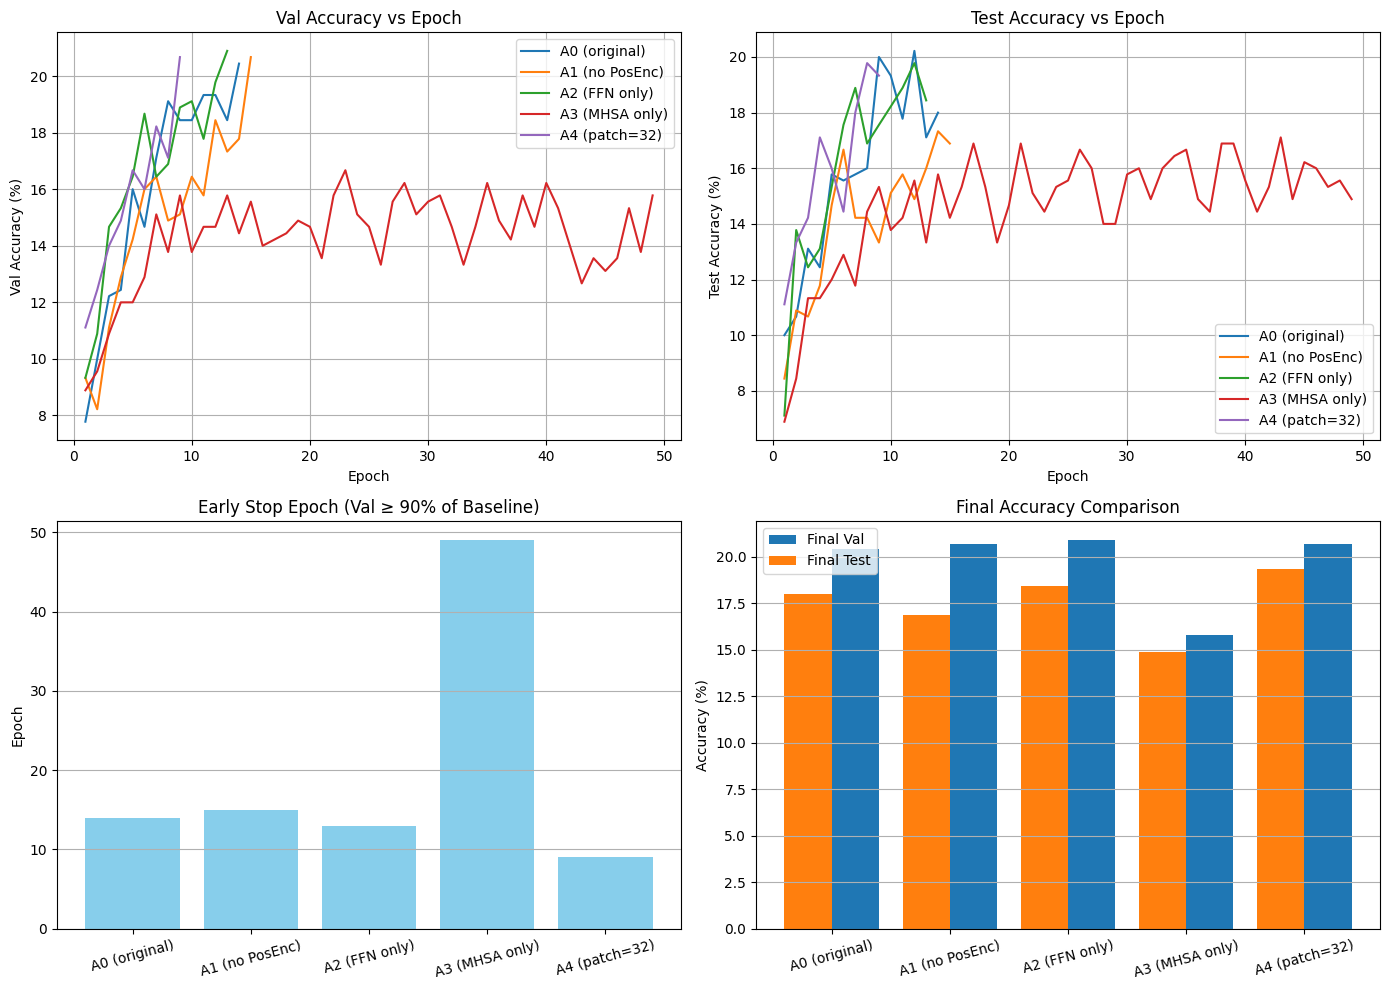

In [30]:
ablation_results = {
    "A0 (original)": {
        "val_acc": [7.78, 10.00, 12.22, 12.44, 16.00, 14.67, 17.11, 19.11, 18.44, 18.44, 19.33, 19.33, 18.44, 20.44],
        "test_acc": [10.00, 10.67, 13.11, 12.44, 15.78, 15.56, 15.78, 16.00, 20.00, 19.33, 17.78, 20.22, 17.11, 18.00]
    },
    "A1 (no PosEnc)": {
        "val_acc": [9.33, 8.22, 11.11, 12.89, 14.22, 16.00, 16.44, 14.89, 15.11, 16.44, 15.78, 18.44, 17.33, 17.78, 20.67],
        "test_acc": [8.44, 10.89, 10.67, 11.78, 14.67, 16.67, 14.22, 14.22, 13.33, 15.11, 15.78, 14.89, 16.00, 17.33, 16.89]
    },
    "A2 (FFN only)": {
        "val_acc": [9.33, 10.89, 14.67, 15.33, 16.44, 18.67, 16.44, 16.89, 18.89, 19.11, 17.78, 19.78, 20.89],
        "test_acc": [7.11, 13.78, 12.44, 13.11, 15.33, 17.56, 18.89, 16.89, 17.56, 18.22, 18.89, 19.78, 18.44]
    },
    "A3 (MHSA only)": {
        "val_acc": [8.89, 9.56, 10.89, 12.00, 12.00, 12.89, 15.11, 13.78, 15.78, 13.78,
                    14.67, 14.67, 15.78, 14.44, 15.56, 14.00, 14.22, 14.44, 14.89, 14.67,
                    13.56, 15.78, 16.67, 15.11, 14.67, 13.33, 15.56, 16.22, 15.11, 15.56,
                    15.78, 14.67, 13.33, 14.67, 16.22, 14.89, 14.22, 15.78, 14.67, 16.22,
                    15.33, 14.00, 12.67, 13.56, 13.11, 13.56, 15.33, 13.78, 15.78],
        "test_acc": [6.89, 8.44, 11.33, 11.33, 12.00, 12.89, 11.78, 14.44, 15.33, 13.78,
                     14.22, 15.56, 13.33, 15.78, 14.22, 15.33, 16.89, 15.33, 13.33, 14.67,
                     16.89, 15.11, 14.44, 15.33, 15.56, 16.67, 16.00, 14.00, 14.00, 15.78,
                     16.00, 14.89, 16.00, 16.44, 16.67, 14.89, 14.44, 16.89, 16.89, 15.56,
                     14.44, 15.33, 17.11, 14.89, 16.22, 16.00, 15.33, 15.56, 14.89]
    },
    "A4 (patch=32)": {
        "val_acc": [11.11, 12.44, 14.00, 14.89, 16.67, 16.00, 18.22, 17.11, 20.67],
        "test_acc": [11.11, 13.33, 14.22, 17.11, 16.00, 14.44, 18.00, 19.78, 19.33]
    }
}

# 🎨 繪圖
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Plot 1: Val Accuracy vs Epoch
for name, result in ablation_results.items():
    axs[0].plot(range(1, len(result["val_acc"]) + 1), result["val_acc"], label=name)
axs[0].set_title("Val Accuracy vs Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Val Accuracy (%)")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Test Accuracy vs Epoch
for name, result in ablation_results.items():
    axs[1].plot(range(1, len(result["test_acc"]) + 1), result["test_acc"], label=name)
axs[1].set_title("Test Accuracy vs Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Test Accuracy (%)")
axs[1].legend()
axs[1].grid(True)

# Plot 3: Early Stop Epochs
early_epochs = [len(result["val_acc"]) for result in ablation_results.values()]
axs[2].bar(ablation_results.keys(), early_epochs, color='skyblue')
axs[2].set_title("Early Stop Epoch (Val ≥ 90% of Baseline)")
axs[2].set_ylabel("Epoch")
axs[2].tick_params(axis='x', rotation=15)
axs[2].grid(True, axis='y')

# Plot 4: Final Accuracy Summary
final_val = [vals["val_acc"][-1] for vals in ablation_results.values()]
final_test = [vals["test_acc"][-1] for vals in ablation_results.values()]
axs[3].bar(ablation_results.keys(), final_val, width=0.4, label="Final Val", align='edge')
axs[3].bar(ablation_results.keys(), final_test, width=-0.4, label="Final Test", align='edge')
axs[3].set_title("Final Accuracy Comparison")
axs[3].set_ylabel("Accuracy (%)")
axs[3].tick_params(axis='x', rotation=15)
axs[3].legend()
axs[3].grid(True, axis='y')

plt.tight_layout()
plt.show()
